In [3]:
#######################
### RB + interleaved RB
from pyquil.simulation.matrices import I, X, Y, Z
import numpy as np
import os
from forest.benchmarking.operator_tools import kraus2pauli_liouville
from print_large import _print_big_matrix
import pickle
from tqdm import tqdm
import multiprocessing as mp
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import reduce
#gateset1 [1, 9601, 8129, 3103, 2296, 0, 0, 9285, 8118, 2974, 3058, 0, 0, 10523, 9788] 5.805
#gateset2 [16192, 11846, 15055, 13880, 10476, 10481] 6.76

#### 2-qubit pauli basis
pauli_basis=[np.asarray(np.kron(i,j)) for i in [I, X, Y, Z] for j in [I, X, Y, Z]]
#### 2-qubit |0> and |1>
e_state=np.kron(np.asarray([[0,0],[0,1]]),np.asarray([[0,0],[0,1]]))
g_state=np.kron(np.asarray([[1,0],[0,0]]),np.asarray([[1,0],[0,0]]))
####Density matrix to PTM
def densityop_01_2_pauli(density_op):
    A=np.asarray([np.trace(density_op@i_den) for i_den in pauli_basis]).reshape(density_op.size,1)
    return A
def densityop_pauli_2_01(density_op):
    A_den=np.asarray([density_op[i_den]*pauli_basis[i_den] for i_den in range(16)])
    B_den=np.zeros((4,4))
    for i_den in A_den:
        B_den=B_den+i_den
    return B_den/4
def dephaseing_PTM(p):
    A=[np.kron(i_deph,j_deph) for i_deph in [I,Z] for j_deph in [I,Z]]
    for i_deph in [0]:
        A[i_deph] = A[i_deph]*np.sqrt(p+(1-p)/4)
    for i_deph in [1,2,3]:
        A[i_deph] = A[i_deph]*np.sqrt((1-p)/4)
#########kraus to PTM 
    return kraus2pauli_liouville(A)
def depolarizing_PTM(p):
    p=1-p
    A=[np.kron(i_depo,j_depo) for i_depo in [I,X,Y,Z] for j_depo in [I,X,Y,Z]]
    A[0] = A[0]*np.sqrt(1-15*p/16)
    for i_depo in range(1,len(A)):
        A[i_depo]=A[i_depo]*np.sqrt(p/16)
#########kraus to PTM        
    return kraus2pauli_liouville(A)
def sequence_to_probability(_rb_seq):
####initial state    
    _state=densityop_01_2_pauli(g_state)
####depo or deph=  noise channel @ Cliff @ state
    if noise_channel==0:
        noise=depolarizing_PTM(noise_strength)
        interleaved_noise=depolarizing_PTM(interleaved_noise_strength)
    elif noise_channel==1:
        noise=dephaseing_PTM(noise_strength)
        interleaved_noise=dephaseing_PTM(interleaved_noise_strength)
    for _i in _rb_seq[:-1]:
        if _i == irb_gate_gateset:
            _state=interleaved_noise@P_PTM[_i]@_state
        else :
            _state=noise@P_PTM[_i]@_state

#### inverse no noise       
    _state=P_PTM[_rb_seq[-1]]@_state
####get [00] prob
    return np.real(densityop_pauli_2_01(_state)[0][0])



In [3]:
c=(10523+9788)/sum([1, 9601, 8129, 3103, 2296, 0, 0, 9285, 8118, 2974, 3058, 0, 0, 10523, 9788])
0.9*c+0.99*(1-c)

0.9626659788264849

In [7]:

if __name__ == '__main__':

####### input
    irb=bool(int(input('irb(1) or NOT (0 )\n')))
    gateset=int(input('gateset \n'))
    max_seq= int(input('max seq \n'))
    noise_channel= int(input('depolarizing (0) or dephasing (1) \n'))
    noise_strength= float(input('noisy(0)-----(1)noiseless\n'))
    interleaved_noise_strength= float(input('interleaved noisy(0)-----(1)noiseless\n'))
    irb_gate=int(input('interleaved gate\n'))
    irb_gate_gateset=int(input('interleaved gate in gateset\n'))
    gateset_path=str(os.path.abspath(os.path.join(os.getcwd(), "../../..")))+'/gateset/'
###primitive gate PTM
    with open(gateset_path+'gateset'+str(gateset)+'/P_PTM_gateset'+str(gateset)+'.pkl', 'rb') as f:
        P_PTM = pickle.load(f)
###rb_seq_deompose
    with open(gateset_path+'gateset'+str(gateset)+'/rb_seq_gateset'+str(gateset)+'.pkl', 'rb') as f:
        rb_seq_decompose = pickle.load(f)
    data={}
####### rb gate number i    
    for i in tqdm(list(filter(lambda x: x<max_seq, list(rb_seq_decompose.keys()))),ascii=True,desc="sequence_length",dynamic_ncols=True):
####### rb sequence into probablility
        pool=mp.Pool()
        repeat_probability = pool.map(sequence_to_probability,rb_seq_decompose[i])
        pool.close()
        pool.join()
        data[i]=repeat_probability
    #df = pd.DataFrame(data)
    #df.to_csv('data.csv')
    with open('rbdata_gateset'+str(gateset)+'.pkl', 'wb') as f:
        pickle.dump(data, f)
#    print('real_p=',(np.real(sum(np.diagonal(dephaseing_PTM(0.9)))-1))/15)
########################################################################################################################
########################################################################################################################
########################################################################################################################
    if irb==True:
###irb_seq_deompose
        with open(gateset_path+'gateset'+str(gateset)+'/'+str(irb_gate)+'irb_seq_gateset'+str(gateset)+'.pkl', 'rb') as f:
            irb_seq_decompose = pickle.load(f)
        irb_data={}
####### irb gate number i    
        for i in tqdm(list(filter(lambda x: x<max_seq, list(irb_seq_decompose.keys()))),ascii=True,desc="sequence_length",dynamic_ncols=True):
####### irb sequence into probablility
            pool=mp.Pool()
            repeat_probability = pool.map(sequence_to_probability,irb_seq_decompose[i])
            pool.close()
            pool.join()
            irb_data[i]=repeat_probability
        #df = pd.DataFrame(data)
        #df.to_csv('data.csv')
        with open(str(irb_gate)+'irbdata_gateset'+str(gateset)+'.pkl', 'wb') as f:
            pickle.dump(irb_data, f)

irb(1) or NOT (0 )
1
gateset 
1
max seq 
100
depolarizing (0) or dephasing (1) 
1
noisy(0)-----(1)noiseless
0.99
interleaved noisy(0)-----(1)noiseless
0.9
interleaved gate
4
interleaved gate in gateset
13


sequence_length: 100%|##########| 99/99 [04:01<00:00,  2.44s/it]


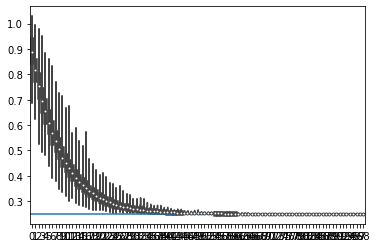

fitting p =  0.97969
fitting perr =  8.7535e-05


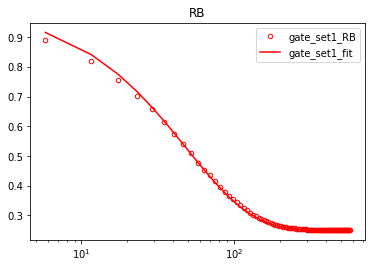

In [8]:

with open('rbdata_gateset'+str(gateset)+'.pkl', 'rb') as f:
    data = pickle.load(f)
sns.violinplot(data=[data[i] for i in list(data.keys())])
plt.axhline(y=0.25)
plt.show()

##########################################################################
### Fit
import numpy as np
import fnmatch
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#fitting function
def fit_p(x,p):
    return 0.75*p**x+0.25
##############
def plot(sequence_length,p_mean,p_std):
#####fit
    sequence_length=[i*5.8 for i in sequence_length]
    mean,cov = curve_fit(fit_p,sequence_length,p_mean,p0=[0.5],bounds=(0,1))
    ##,sigma=p_std, absolute_sigma = True,
    print('fitting p = ','%.5g' % mean[0])
    print('fitting perr = ','%.5g' % np.sqrt(np.diag(cov)))
########plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(sequence_length,p_mean,'.',color='r',markerfacecolor='none',markersize=9,label='gate_set1_RB')
    ax.plot(sequence_length,fit_p(sequence_length, mean),'-',color='r',label='gate_set1_fit')

    #ax.set_xscale('log')
    ax.legend(loc='best')
    plt.xscale('log')
    plt.title('RB')
    plt.savefig('RB'+str(gateset)+'.png')
plot(list(data.keys()),[np.mean(data[i]) for i in data],[np.std(data[i]) for i in data])


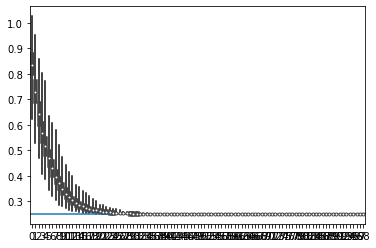

fitting p =  0.9652
fitting perr =  0.00013668


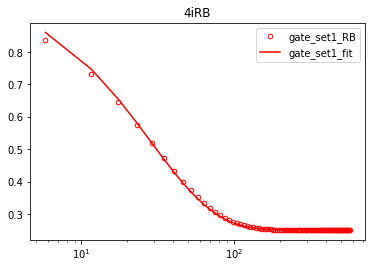

In [9]:

with open(str(irb_gate)+'irbdata_gateset'+str(gateset)+'.pkl', 'rb') as f:
    data = pickle.load(f)
sns.violinplot(data=[data[i] for i in list(data.keys())])
plt.axhline(y=0.25)
plt.show()

##########################################################################
### Fit
import numpy as np
import fnmatch
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#fitting function
def fit_p(x,p):
    return 0.75*p**x+0.25
##############
def plot(sequence_length,p_mean,p_std):
#####fit
    sequence_length=[i*5.8 for i in sequence_length]
    mean,cov = curve_fit(fit_p,sequence_length,p_mean,p0=[0.5],bounds=(0,1))
    ##,sigma=p_std, absolute_sigma = True,
    print('fitting p = ','%.5g' % mean[0])
    print('fitting perr = ','%.5g' % np.sqrt(np.diag(cov)))
########plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(sequence_length,p_mean,'.',color='r',markerfacecolor='none',markersize=9,label='gate_set1_RB')
    ax.plot(sequence_length,fit_p(sequence_length, mean),'-',color='r',label='gate_set1_fit')

    #ax.set_xscale('log')
    ax.legend(loc='best')
    plt.xscale('log')
    plt.title(str(irb_gate)+'iRB')
    plt.savefig(str(irb_gate)+'iRB'+str(gateset)+'.png')
plot(list(data.keys()),[np.mean(data[i]) for i in data],[np.std(data[i]) for i in data])


In [13]:
0.9652/0.97969

0.9852096071206198

In [10]:
print('real_p=',(np.real(sum(np.diagonal(dephaseing_PTM(0.99)))-1))/15)

real_p= 0.9920000000000001


In [12]:
0.992*11519/11520+0.92/11520

0.99199375